In [4]:
# imports
import numpy as np
import random
import math
import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [5]:
# Read data functions
def string_to_spin(string):
    """
    Convert string of 0 and 1 to a np array of spins (-1, 1):
    0 -> -1
    1 -> +1
    :param string: String: original string.
    :return: np.array: Spins.
    """
    return (np.array(list(map(int, list(string)))) * 2 - 1)

def read_configurations(name, n):
    """
    Reads a file and returns a np array with the spin configuration.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Matrix of shape (Data_number, num_spins).
    """
    spins = np.array([])
    filepath = name
    with open(filepath, 'r') as fp:
        s = fp.readlines()  
    spins = np.array([string_to_spin(e.rstrip()) for e in s]).flatten()
    return np.reshape(spins, (int(len(spins)/n), n)).astype('int')

def read_j_coef(name, n):
    """
    Reads a file and returns a np array with the j coefficients.
    :param name: String: Name of the file.
    :param n: Int: Number of spins.
    :return: np.array: Array of shape 2*n.
    """
    j = np.zeros((n, 2))
    filepath = name
    with open(filepath) as fp:
        for line in tqdm_notebook(fp.readlines()):
            list_line = line.split()
            if len(list_line) == 2:
                el = list_line[-1]
                list_line[-1] = el[0]
                list_line.append(el[1:])
            s = int(list_line[0])-1
            d = int(list_line[1])-1
            # list line té 3 llocs: numspin, (1 o 2) i el valor de J
            j[s, d] = list_line[-1]
    return j

In [6]:
# get neighbours
def get_spin_neighbours(i, l):
    """
    From a spin i in a lxl grid, gives the neighbours of this spin.
    :param i: Int: Position of the spin.
    :param l: Int: Length of the square grid.
    :return: np.array: Array containing the index of the neighbour spins.
    """
    column = int(i % l)
    row = int(i / l)
    right = int(row * l + (column + 1)%l)
    up = int(((row + 1)%l) * l + column)
    left = int(row * l + (column - 1)%l)
    down = int(((row - 1)%l) * l + column)
    return np.array([right, up, left, down])

def f_nbrs(n):
    l = int(np.sqrt(n))
    return np.array([get_spin_neighbours(i, l) for i in range(n)])

In [21]:
# Pseudolikelihood calculation
def log_pseudolikelihood2(data, nbrs, h, j, temp=1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    output = np.array([[1 + data[mu, i] * math.tanh(float(h[i])/temp + multiply_j_spin_neighbours(j, data[mu, :], i, nbrs[i])/temp) for i in range(n)] for mu in range(m)])
    output = np.log(output)
    return -np.sum(output)/m

def multiply_j_spin_neighbours(j, spins, i, nbr):
    subsum = spins[nbr[0]] * j[i, 0] + spins[nbr[2]] * j[nbr[2], 0] \
        + spins[nbr[1]] * j[i, 1] + spins[nbr[3]] * j[nbr[3], 1]
    return float(subsum)

def tanh_class(h, j, alpha, i, nbr, temp):
    spins = int_to_spins_5(alpha)
    subsum = spins[0] * j[i, 0] + spins[1] * j[nbr[2], 0] + spins[2] * j[i, 1] + spins[3] * j[nbr[3], 1]
    return spins[4]*math.tanh(float(h[i] + subsum)/temp)

def class_matrix(data):
    m, n = data.shape
    nbrs = f_nbrs(n)
    classes = np.zeros((n, 32), dtype='int')
    for mu in range(m):
        for i in range(n):
            spins = [data[mu, nbrs[i][0]], data[mu, nbrs[i][2]], data[mu, nbrs[i][1]], data[mu, nbrs[i][3]], data[mu, i]]
            classes[i, spins_to_int(spins)] += 1
    return classes


def log_pseudolikelihood_opt(data, nbrs, h, j, classes, temp=1, recalculate = True, previous = 0, h_prev=None, j_prev=None, new_row = -1):
    m, n = data.shape
    out = 0
    for i in range(n):
        for alpha in range(32):
            c_i_alpha = classes[i, alpha]
            if c_i_alpha != 0:
                out += c_i_alpha * math.log(1 + tanh_class(h, j, alpha, i, nbrs[i], temp))
    return -float(out)/m

def pseudolikelihood_gradient_descent(j, data, nbrs, classes, temp):
    m, n = data.shape
    h = np.zeros(n)
    return log_pseudolikelihood(data, nbrs, h, j, classes, temp=temp)

def pseudolikelihood_gradient_descent_penalty(j, data, nbrs, classes, temp, penalty=0.):
    m, n = data.shape
    h = np.zeros(n)
    return log_pseudolikelihood(data, nbrs, h, j, classes, temp=temp) + penalty * np.sum(j**2)

def int_to_spins_5(alpha):
    return string_to_spin(format(alpha, '05b'))

def int_to_spins_10(alpha):
    return string_to_spin(format(alpha, '010b'))

def spins_to_int(spins):
    out = ''
    for e in spins:
        out += str(int((e+1)/2))
    return int(out, 2)





# Pseudolikelihood calculation
def log_pseudolikelihood(data, nbrs, h, j, classes, temp=1, recalculate = True, previous = 0, h_prev=None, j_prev=None, new_row = -1):
    """Sums the rows of the pseudolikelihood"""
    m, n = data.shape
    if recalculate:
        output = 0
        for i in range(n):
            output += log_pseudolikelihood_row(data, h, j, classes, temp, i, nbrs)
        return -float(output)/m
    else:
        delta = 0
        for r in new_row:
            delta += float(log_pseudolikelihood_row(data, h_prev, j_prev, classes, temp, r, nbrs) - log_pseudolikelihood_row(data, h, j, classes, temp, r, nbrs))
        return previous + delta/m
        


def log_pseudolikelihood_row(data, h, j, classes, temp, i, nbrs):
    """
    Computes the pseudolikelihood for each row i.
    """
    m, n = data.shape
    out = 0
    for alpha in range(32):
        c_i_alpha = classes[i, alpha]
        if c_i_alpha != 0:
            out += c_i_alpha * math.log(1 + tanh_class(h, j, alpha, i, nbrs[i], temp))
    return out

def multiply_j_spin_neighbours(j, spins, i, nbr):
    n, d = j.shape
    subsum = 0
    for k in range(d):
        subsum += spins[nbr[k]] * j[i, k] + spins[nbr[k + d]] * j[nbr[k + d], k] 
    return float(subsum)

In [22]:
def hamiltonian(spins, h, j):
    hamiltonian = 0
    n, d = j.shape
    l = int(np.sqrt(n))
    for i in range(n):
        subsum = 0
        for k in range(d):
            subsum += spins[get_spin_neighbours(i, l)[k]] * j[i, k]
        hamiltonian += spins[i] * subsum
    hamiltonian += np.dot(h, spins)
    return -hamiltonian

In [23]:
# Create random h and J of given dimension
def get_random_h_j(n, d=2):
    h = np.random.uniform(-1, 1, size=n)
    j = np.random.uniform(-1, 1, size=(n,d))
    return h, j

def mean_error(h, j, hp, jp, magnetic_field=True):
    n, = h.shape
    numerator = np.linalg.norm(flat_matrix(j) - flat_matrix(jp))**2 + np.linalg.norm(h-hp)**2
    denominator = np.linalg.norm(flat_matrix(jp))**2 + np.linalg.norm(hp)**2
    return np.sqrt(numerator/denominator)


def neighbour_uniform(s, delta=0.5):
    lower = max(s - delta, -1.)
    upper = min(s + delta, 1.)
    return np.random.uniform(lower, upper)

def random_change_h_j_row(h, j, nbrs, delta=0.5, magnetic_field=True):
    if magnetic_field:
        h_new = np.copy(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d+1)
        if row == d:
            # h must be changed
            h_new[column] = neighbour_uniform(h_new[column], delta)
            return h_new, j_new, (column,)
        else:
            # j must be changed
            j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
            return h_new, j_new, (column, nbrs[column][row])
    else:
        h_new = np.zeros_like(h)
        j_new = np.copy(j)
        n, d = j_new.shape
        column = np.random.randint(0, n)
        row = np.random.randint(0, d)
        # j must be changed
        j_new[column, row] = neighbour_uniform(j_new[column, row], delta)
        return h_new, j_new, (column, nbrs[column][row])
    
def energy(temp, func, func_new):
    return math.exp(-(func_new - func) / temp)

In [24]:
# Simulated annealing

def simulated_algorithm_min_multi(data, hreal, jreal, real_temp=1, magnetic_field=True, values=None, mc_steps=800, temp_ini=2, frac_annealing=0.9):
    start = timeit.default_timer()
 
    m, n = data.shape
    if values is None:
        h0, j0 = get_random_h_j(n)
    else:
        h0, j0 = values
    print('Time values: ', timeit.default_timer() - start) 
    classes = class_matrix(data)
    h_iter, j_iter = h0, j0
    h_min, j_min = h0, j0
    nbrs = f_nbrs(n)
    print('Time nbrs: ', timeit.default_timer() - start) 
    func_iter = log_pseudolikelihood(data, nbrs, h_iter, j_iter, classes, temp=real_temp)
    print('Time log: ', timeit.default_timer() - start) 
    func_min = func_iter
    rec = False
    error = []
    min_vals = []
    max_num_iters = int(2*n*mc_steps)
    iters_annealing = int(max_num_iters*frac_annealing)
    iters_t_zero = max_num_iters - iters_annealing
    initial_delta=0.3
    print('Time: start', timeit.default_timer() - start) 
    for k in tqdm_notebook(range(iters_annealing), leave=True):
        if k%200 == 0:
            rec = True
        error.append(mean_error(h_iter, j_iter, hreal, jreal, magnetic_field=magnetic_field))
        min_vals.append(func_iter)
        temp = temp_ini * np.exp(-5.0*k/iters_annealing)
        h_new, j_new, row = random_change_h_j_row(h_iter, j_iter, nbrs, delta=initial_delta, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, classes, temp=real_temp, recalculate=rec, previous=func_iter, h_prev=h_iter, j_prev=j_iter, new_row=row)
        rec = False
        if func_new < func_iter:
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
            if func_new < func_min:
                h_min, j_min = h_new, j_new
                func_min = func_new
        elif random.random() < energy(temp, func_iter, func_new):
            h_iter, j_iter = h_new, j_new
            func_iter = func_new
    print('Time: end1', timeit.default_timer() - start) 

    for k in tqdm_notebook(range(iters_t_zero)):
        error.append(mean_error(h_min, j_min, hreal, jreal, magnetic_field=magnetic_field))
        #delta = initial_delta * (iters_t_zero - k) / iters_t_zero
        delta=initial_delta
        h_new, j_new, row = random_change_h_j_row(h_min, j_min, nbrs, delta=delta, magnetic_field=magnetic_field)
        func_new = log_pseudolikelihood(data, nbrs, h_new, j_new, classes, temp=real_temp, recalculate=False, previous=func_min, h_prev=h_min, j_prev=j_min, new_row=row)
        if func_new < func_min:
            h_min, j_min = h_new, j_new
            func_min = func_new
    print('Time: end2', timeit.default_timer() - start) 
    return (h_min, j_min, func_min), error, min_vals

In [25]:
def flat_matrix(a):
    return a.flatten()

In [26]:
def write_error_to_file(filename, error):
    f = open(filename, "w+")
    for e in error:
        f.write(str(e)+"\n")
    f.close()
def read_error_from_file(filename):
    with open(filename, 'r') as fp:
        s = fp.readlines()
    return np.array([e.strip() for e in s], dtype='float')

In [27]:
def write_arr_to_file(filename, arr1, arr2):
    f = open(filename, "w+")
    for e1, e2 in zip(arr1, arr2):
        f.write(str(e1)+' '+str(e2)+"\n")
    f.close()
def read_arr_from_file(filename):
    arr1 = []
    arr2 = []
    with open(filename, 'r') as fp:
        s = fp.readlines()
    for e in s:
        arr1.append(e.split()[0])
        arr2.append(e.split()[1])

    return np.array(arr1, dtype='float'), np.array(arr2, dtype='float')

In [65]:
size_sample = 25000
max_iterations = 1000
n = 16
t1, t2, t3 = 0.5, 1.08304286, 2.0
j1 = read_j_coef('L4/sample1/bonds.dat', n)
h = np.zeros(n)
spins = read_configurations('L4/sample1/configurations_T1.dat', n)
spins = spins[::4]# en el cas de n=16
sample1 = spins[np.random.choice(spins.shape[0], size=size_sample, replace=False), :]
print(sample1.shape)


(25000, 16)


In [66]:
print(class_matrix(sample1).sum())

400000


In [67]:
start = timeit.default_timer()
result1 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t1, mc_steps=max_iterations, magnetic_field=False)
result2 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t1, mc_steps=max_iterations, magnetic_field=False)
result3 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t1, mc_steps=max_iterations, magnetic_field=False)
result4 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t1, mc_steps=max_iterations, magnetic_field=False)
result5 = simulated_algorithm_min_multi(sample1, h, j1, real_temp=t1, mc_steps=max_iterations, magnetic_field=False)
print('TOTAL TIME:', timeit.default_timer() - start)

Time values:  3.724199996213429e-05
Time nbrs:  2.233236738999949
Time log:  2.2443893729998763
Time: start 2.246710394999809



Time: end1 72.51826583999991



Time: end2 80.21461050199991
Time values:  3.606899986152712e-05
Time nbrs:  2.274015757999905
Time log:  2.2850903900000503
Time: start 2.290302204999989



Time: end1 71.86221194699988



Time: end2 79.55233896799996
Time values:  3.3428999813622795e-05
Time nbrs:  2.307017959999939
Time log:  2.318100215999948
Time: start 2.320000433999894



Time: end1 72.19381572999987



Time: end2 79.87679347700009
Time values:  2.170000016121776e-05
Time nbrs:  2.308052231000147
Time log:  2.3189497429998482
Time: start 2.322043168000164



Time: end1 71.86604903800026



Time: end2 79.47284507199993
Time values:  0.00015131300006032689
Time nbrs:  2.3154070680002405
Time log:  2.3264910839998265
Time: start 2.32901620299981



Time: end1 71.69246798299991



Time: end2 79.30178767000007
TOTAL TIME: 398.4349198980001


In [68]:
avg = np.mean(np.vstack((result1[1],result2[1],result3[1],result4[1],result5[1])), axis=0)
std = np.std(np.vstack((result1[1],result2[1],result3[1],result4[1],result5[1])), axis=0, ddof=1)
write_error_to_file('L4_T1_S1_exp/L4_T1_S1_error_m25000_t1000_avg.txt', avg)
write_error_to_file('L4_T1_S1_exp/L4_T1_S1_error_m25000_t1000_std.txt', std)

In [69]:
from matplotlib import rc
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["mathtext.fontset"] = "cm"

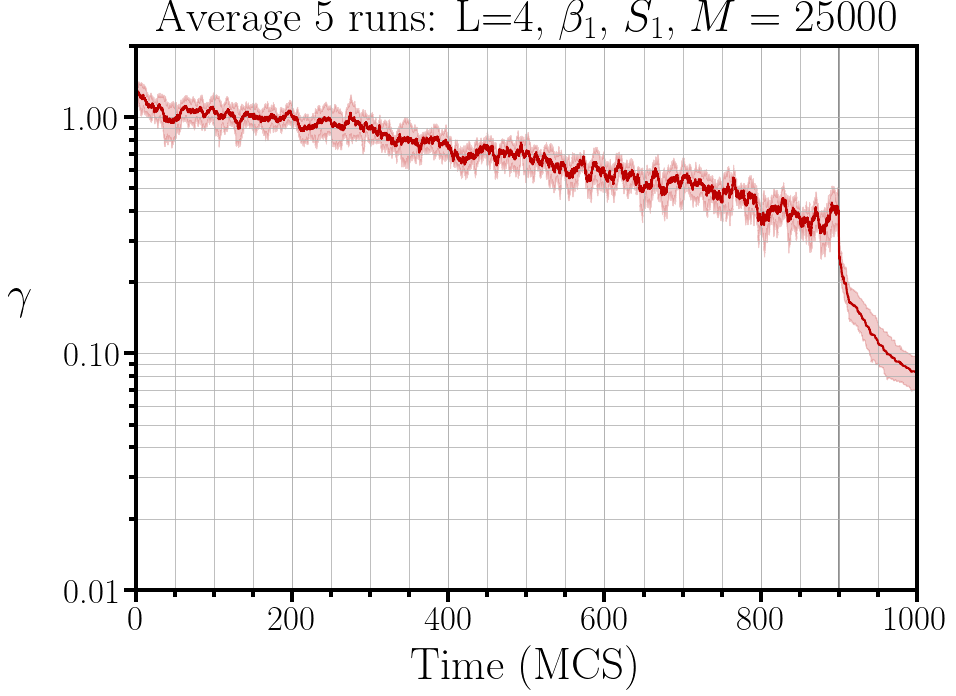

In [73]:
x = np.arange(len(result1[1]))/32
wl=2
colors_dif = [[255,0,0], [255,91,0], [255,198,0], [198,255,0], [91,255,0], [0,255,0], [0,255,91], [0,255,198], [0,198,255], [0,91,255]]
colors_dif = np.array(colors_dif)/255.0
color1, color2, color3 = '#bb0000', '#00bb00', '#0000bb'
plt.figure(figsize = (14, 10))
ax = plt.axes()
plt.title(r'Average 5 runs: L=4, $\beta_1$, $S_1$, $M=25000$', fontsize=45, y=1.005)
plt.xlabel(r'Time (MCS)', rotation=0, fontsize=45)
plt.ylabel(r'$\gamma$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.15, 0.5)
#plt.plot(x, result1[1], color=colors_dif[0])
#plt.plot(x, result2[1], color=colors_dif[2])
#plt.plot(x, result3[1], color=colors_dif[4])
#plt.plot(x, result4[1], color=colors_dif[6])
#plt.plot(x, result5[1], color=colors_dif[8])
plt.plot((np.max(x)*0.9, np.max(x)*0.9), (1e-2,2), color='#444444', label='y=x', zorder=1, linewidth=2, alpha=0.6)

plt.plot(x, avg, color=color1, linewidth=wl)
plt.fill_between(x, avg - std, avg + std, color=color1, alpha=0.2)

plt.yscale('log')
plt.ylim(1e-2, 2)
plt.xlim(0, np.max(x))

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.legend()
#plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
plt.grid(True, which='both')
plt.savefig('L4_T1_S1_exp/error_L4_T1_S1_M25000_t1000.png', bbox_inches = 'tight')
plt.show()


In [ ]:
print('L4_T1_S1_error:{}'.format(mean_error(h, result1[0][1], h, j1)))
#print('L4_T1_S2_error:{}'.format(mean_error(h, result2[0][1], h, j2)))
#print('L4_T1_S3_error:{}'.format(mean_error(h, result3[0][1], h, j3)))
print(result1[0][1])

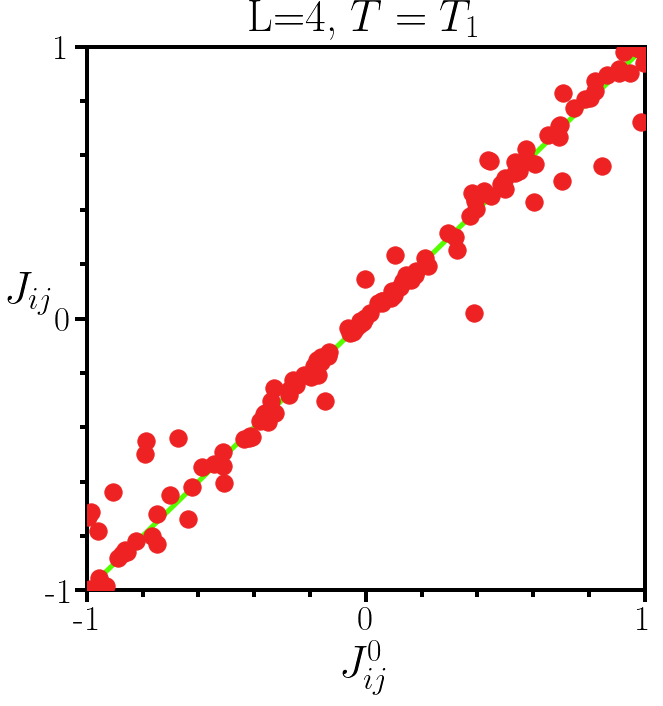

In [64]:
plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.title('L=4, $T=T_1$', fontsize=45, y=1.005)
plt.xlabel('$J^{0}_{ij}$', rotation=0, fontsize=45)
plt.ylabel('$J_{ij}$', rotation=0, fontsize=45)
ax.xaxis.set_label_coords(0.5, -0.1)
ax.yaxis.set_label_coords(-0.1, 0.5)
plt.plot((-1, 1), (-1,1), color='#55ff00', label='y=x', zorder=1, linewidth=5, alpha=1)
plt.scatter(flat_matrix(j1), flat_matrix(result1[0][1]), color='#ee2222', label='Sample 1', zorder=6, marker="o", s=300)
#plt.scatter(flat_matrix(j2), flat_matrix(result2[0][1]), color='#E8B201', label='Sample 2', zorder=5, marker="v", s=300)
#plt.scatter(flat_matrix(j3), flat_matrix(result3[0][1]), color='#2222ee', label='Sample 3', zorder=4, marker="^", s=300)
#plt.scatter(flat_sym_matrix(j8), flat_sym_matrix(result8[1]), color='#009900', label='N=8', zorder=5, marker="v")
#plt.scatter(flat_sym_matrix(j12), flat_sym_matrix(result12[1]), color='#2222ee', label='N=12', zorder=4, marker="^")
#plt.scatter(flat_sym_matrix(j16), flat_sym_matrix(result16[1]), color='#E8B201', label='N=16', zorder=3, marker="s")
#plt.scatter(flat_sym_matrix(j20), flat_sym_matrix(result20[1]), color='#B300FF', label='N=20', zorder=2, marker="D")

plt.ylim(-1, 1)
plt.xlim(-1, 1)

# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.2))
# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=12)
ax.tick_params(which='minor', length=7)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(4)
#plt.grid()
#plt.legend()
#plt.savefig('L4_T1.png', bbox_inches = 'tight')
plt.show()



In [ ]:
#write_arr_to_file('M25000_L4_T1_S1_j.txt', flat_matrix(j1), flat_matrix(result1[0][1]))
#write_arr_to_file('M25000_L4_T1_S2_j.txt', flat_matrix(j2), flat_matrix(result2[0][1]))
#write_arr_to_file('M25000_L4_T1_S3_j.txt', flat_matrix(j3), flat_matrix(result3[0][1]))

In [ ]:
from skimage import io, exposure, color, img_as_float, img_as_int, img_as_uint, img_as_ubyte
image = io.imread('test2.png')
def two_images(img1, img2, savename):
    io.imsave(savename, np.hstack((img1, img2)))
def three_images(img1, img2, img3, savename):
    io.imsave(savename, np.vstack((img1, img2, img3)))
two_images(image, image, 'test_joined.png')
image = io.imread('test_joined.png')
three_images(image, image, image, 'test_joined_final.png')